# Lily's physiological data analysis

This script:

1. loads in all the participant data
2. Cleans up the data accordingly i.e. renames columns etc. 
3. Plots the raw data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter
import os

import pingouin as pg
from statannot import add_stat_annotation

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# path = "C:/Users/VR-Lab/Documents/Projects/LH_Project/Data/"
path = "C:/Users/Monter/Projects/LH_Project/Data/"

### Functions

In [4]:
def RMSSD_Compute(data_df, plotting=False):
    
    # Example trial from an example participant for testing and understanding HRV
    # testmask = (df['Participant_ID'] == 'yu191230') & (df['phase'] == 'Phase_1')

    # Get the values into a new variable for ease of use 
    vals = data_df['heart_rate'].values

#     # Compute the sampling rate using time and number of samples 
#     trialDuration = data_df['time'].values[-1] - data_df['time'].values[0] # in seconds 
#     numbSamples = len(data_df['time'].values)
#     sampleRate = np.round(numbSamples/trialDuration)

    # Find the peaks using an arbitrary height value, i.e. ignore all peaks below that value e.g. 600
    pks,_ = find_peaks(vals, height=750, prominence=150, distance=25)

    heart_rate = len(pks) # number of peaks in a minute 
    RR = np.diff(pks)
    rmssd = np.sqrt(np.mean(np.square(np.diff(RR)))) # Same formula as Lily's document 
    # standardDeviationOfRR = np.std(RR)
    
#     print("Val: " + str(rmssd) + " Type: " + str(type(rmssd)))
    
    if plotting:
        # Display plots of the heart rate and detected peaks 
        plt.plot(vals, color='r', linewidth=2)
        plt.plot(pks, vals[pks],'xk',markersize=8)
        plt.xlim([0,500])
        plt.xlabel('Time / s', fontsize=14)
        plt.ylabel('ECG', fontsize=14)
        plt.savefig('HeartRate_Example.png', dpi=600, bbox_inches='tight')
    
    return rmssd

## 1. Load all participant data collected so far

In [5]:
files = os.listdir(path)

tmpDF = None
df = None

for file in files:
    if 'json' in file:
        tmpDF = pd.read_json(path+file)
        
        if df is None:
            df = tmpDF
        else:
            df = pd.concat((df, tmpDF))        
df.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,541,39,0.291603,startNow,AC071320,1,1
1,476,77,0.301579,startNow,AC071320,1,1
2,419,115,0.311549,startNow,AC071320,1,1


## 2. Clean up the data 

### List phases present in the experiment

In [6]:
participants_to_update = df.loc[df['phase'] == 'calm_1o3', 'Participant_ID'].unique()

# Update "Condition" column to 0 for rows belonging to identified participants
for participant in participants_to_update:
    df.loc[df['Participant_ID'] == participant, 'Condition'] = 0
    
df.head(3)

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,541,39,0.291603,startNow,AC071320,1,1
1,476,77,0.301579,startNow,AC071320,1,1
2,419,115,0.311549,startNow,AC071320,1,1


### For ease of analysis, rename the stress and calm conditions to numbers

e.g.
stress_1o1 and calm_1o1 will become p1 and 
stress_1o2 and calm_1o2 will become p2 etc. 

We can afford to do this now because we separated out the conditions to 0 for calm and 1 for stress so we do not need the phases in order to tell which condition the participant experienced in the experiment

This will make plotting the figures simpler, i.e. instead of seeing 6 phases (3 for the calm plut 3 for the stress conditions) we now only see 3 phases in total and we use the condition parameter to separate out which is stress and which is calm

In [7]:
# Rename the conditions from numbers to words i.e. condition 0 = calm and condition 1 = stress 
df['Condition'] = df['Condition'].replace({0: 'Calm', 1: 'Stress'})
df['Condition'] = df['Condition'].replace({3: 'Stress'})

# Rename the 3 phases in the calm and stress conditions to phases 1 to 3
df['phase'] = df['phase'].replace({'calm_1o3': 'Phase_1', 'stress_1o3': 'Phase_1'})
df['phase'] = df['phase'].replace({'calm_2o3': 'Phase_2', 'stress_2o3': 'Phase_2'})
df['phase'] = df['phase'].replace({'calm_3o3': 'Phase_3', 'stress_3o3': 'Phase_3'})

# Rename calm or stress end phases to phase end 
df['phase'] = df['phase'].replace({'calm_end': 'Washout', 'stress_end': 'Washout'})

# Rename to baseline for the initial baseline part of the experiment
df['phase'] = df['phase'].replace({'end_instructions': 'Baseline'})


In [8]:
pd.unique(df['Condition'])

array(['Stress', 'Calm'], dtype=object)

In [9]:
pd.unique(df['phase'])

array(['startNow', 'start_experiment', 'buggy_journey',
       'fix_buggy_instructions', 'storm_instructions', 'Baseline',
       'Phase_1', 'Phase_2', 'Phase_3', 'Washout', 'experiment_end'],
      dtype=object)

### For the analysis, only use those phases that are relevant for your particular intervention and exclude the rest, which is what we are doing here

In [76]:
excludePhases = (df['phase']!='startNow') & (df['phase']!='start_experiment') & (df['phase']!='buggy_journey') & (df['phase']!='fix_buggy_instructions') & (df['phase']!='storm_instructions') & (df['phase']!='experiment_end') & (df['Participant_ID']!= 3)

## 3. Raw data plots

### Here use the above selected phases on your plots and for the analysis to filter the data 

#### For GSR we may need to normalise according to each participant's baseline values

In [11]:
# We took the inverse of the resistance to convert the values to conductance 
# df['gsr_response'] = 1/df['gsr_response']

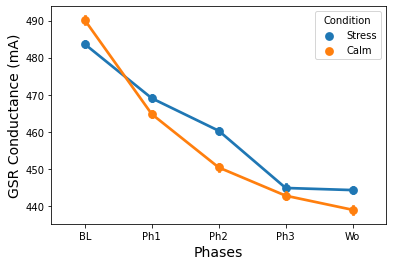

In [12]:
ax1 = sns.pointplot(x='phase',y='gsr_response', data=df[excludePhases], hue='Condition')
# ax1.tick_params(axis='x', rotation=90)

plt.xlabel('Phases',fontsize=14)
plt.xticks([0,1,2,3,4], ['BL','Ph1','Ph2','Ph3','Wo'])
plt.ylabel('GSR Conductance (mA)',fontsize=14)

plt.savefig("GSR.png", dpi=300)

In [13]:
pg.normality(df[excludePhases]['gsr_response'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
gsr_response,0.973095,0.0,False


In [14]:
# mask = (result_df['Condition'] == 'Calm')
# print('Mean calm: ' + str(np.round(np.mean(result_df[mask]['Difference']),3)) + " SD: " + str(np.round(np.std(result_df[mask]['Difference']),3)))

# mask = (result_df['Condition'] == 'Stress')
# print('Mean stress: ' + str(np.round(np.mean(result_df[mask]['Difference']),3)) + " SD: " + str(np.round(np.std(result_df[mask]['Difference']),3)))

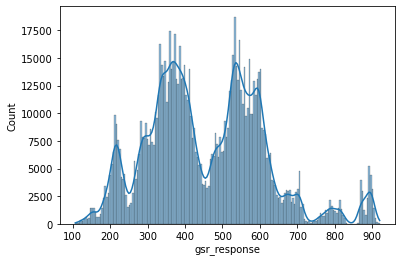

In [15]:
sns.histplot(df[excludePhases]['gsr_response'],kde=True)
plt.savefig("GSR distribution.png", dpi=300)

In [16]:
df.dropna(inplace=True)

In [17]:
md = smf.mixedlm("gsr_response ~ (phase*Condition)", data=df[excludePhases], groups=df[excludePhases]["Participant_ID"])
mdf = md.fit()
print(mdf.summary())

                        Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          gsr_response 
No. Observations:          1047538          Method:                      REML         
No. Groups:                39               Scale:                       844.6737     
Min. group size:           22804            Log-Likelihood:              -5016292.7907
Max. group size:           27660            Converged:                   Yes          
Mean group size:           26859.9                                                    
--------------------------------------------------------------------------------------
                                       Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------------
Intercept                              484.465   24.379   19.872 0.000 436.683 532.248
phase[T.Phase_1]                       -19.025    0.131 -144.714 0.0

In [77]:
newDF_GSR = df[excludePhases]

### Example sentence for the GSR results

For the GSR responses we found a main effect of phase across all phases, where the GSR conducatance in the Stress group seemed to be overall higher at each of the phases compared to the Calm condition.    

In [82]:
print('Calm')

mask = (newDF_GSR['Condition'] == 'Calm') &  (newDF_GSR['phase'] == 'Phase_1')
print('Mean GSR phase_1: ' + str(np.round(np.mean(newDF_GSR[mask]['gsr_response']),3)) + " SD: " + str(np.round(np.std(newDF_GSR[mask]['gsr_response']),3)))

mask = (newDF_GSR['Condition'] == 'Calm') &  (newDF_GSR['phase'] == 'Phase_2')
print('Mean GSR phase_2: ' + str(np.round(np.mean(newDF_GSR[mask]['gsr_response']),3)) + " SD: " + str(np.round(np.std(newDF_GSR[mask]['gsr_response']),3)))

mask = (newDF_GSR['Condition'] == 'Calm') &  (newDF_GSR['phase'] == 'Phase_3')
print('Mean GSR phase_3: ' + str(np.round(np.mean(newDF_GSR[mask]['gsr_response']),3)) + " SD: " + str(np.round(np.std(newDF_GSR[mask]['gsr_response']),3)))

mask = (newDF_GSR['Condition'] == 'Calm') &  (newDF_GSR['phase'] == 'Washout')
print('Mean GSR Washout: ' + str(np.round(np.mean(newDF_GSR[mask]['gsr_response']),3)) + " SD: " + str(np.round(np.std(newDF_GSR[mask]['gsr_response']),3)))

print('\nStress')

mask = (newDF_GSR['Condition'] == 'Stress') &  (newDF_GSR['phase'] == 'Phase_1')
print('Mean GSR phase_1: ' + str(np.round(np.mean(newDF_GSR[mask]['gsr_response']),3)) + " SD: " + str(np.round(np.std(newDF_GSR[mask]['gsr_response']),3)))

mask = (newDF_GSR['Condition'] == 'Stress') &  (newDF_GSR['phase'] == 'Phase_2')
print('Mean GSR phase_2: ' + str(np.round(np.mean(newDF_GSR[mask]['gsr_response']),3)) + " SD: " + str(np.round(np.std(newDF_GSR[mask]['gsr_response']),3)))

mask = (newDF_GSR['Condition'] == 'Stress') &  (newDF_GSR['phase'] == 'Phase_3')
print('Mean GSR phase_3: ' + str(np.round(np.mean(newDF_GSR[mask]['gsr_response']),3)) + " SD: " + str(np.round(np.std(newDF_GSR[mask]['gsr_response']),3)))

mask = (newDF_GSR['Condition'] == 'Stress') &  (newDF_GSR['phase'] == 'Washout')
print('Mean GSR Washout: ' + str(np.round(np.mean(newDF_GSR[mask]['gsr_response']),3)) + " SD: " + str(np.round(np.std(newDF_GSR[mask]['gsr_response']),3)))



Calm
Mean GSR phase_1: 464.798 SD: 160.721
Mean GSR phase_2: 450.436 SD: 165.517
Mean GSR phase_3: 442.838 SD: 169.748
Mean GSR Washout: 439.036 SD: 178.707

Stress
Mean GSR phase_1: 469.072 SD: 132.921
Mean GSR phase_2: 460.315 SD: 138.776
Mean GSR phase_3: 444.916 SD: 149.29
Mean GSR Washout: 444.351 SD: 149.064


In [18]:
# pg.mixed_anova(dv='gsr_response', between='Condition', within='phase',
#                subject='Participant_ID', effsize="ng2", data=df[excludePhases]).round(3)

### Heart rate 

In [19]:
# ax2 = sns.pointplot(x='phase', y='heart_rate', data=df[excludePhases], hue='Condition')
# ax2.tick_params(axis='x', rotation=90)

## 4. Hear-Rate-Variability (HRV) Computation

In [20]:
pd.unique(df['phase'])

array(['startNow', 'start_experiment', 'buggy_journey',
       'fix_buggy_instructions', 'storm_instructions', 'Baseline',
       'Phase_1', 'Phase_2', 'Phase_3', 'Washout', 'experiment_end'],
      dtype=object)

### Compute the Heart Rate Varibility (HRV) 
Use a window of a certain size (experiment with different window sizes) to compute this value

### RMSSD (Root Mean Square of Successive Differences)

In [21]:
testmask = (df['Participant_ID'] == 'yu191230') & (df['phase'] == 'Phase_1')
rmssdVal = RMSSD_Compute(df[testmask])
print('RMSSD: ' + str(rmssdVal))

RMSSD: 12.976526650164866


In [22]:
df[testmask]['time'].values[-1] - df[testmask]['time'].values[0]

57.58991

In [23]:
numbptx = pd.unique(df['Participant_ID'])
print('Number of participants: ' + str(len(numbptx)))

Number of participants: 41


In [24]:
newDF = None
newDF = df.groupby(['Participant_ID', 'Condition', 'phase']).apply(lambda x: RMSSD_Compute(x)).reset_index().rename(columns={df.index.name:'RMSSD'})

newDF.rename(columns={0: "RMSSD"}, inplace=True)
newDF

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Participant_ID,Condition,phase,RMSSD
0,3,Stress,Baseline,85.856430
1,3,Stress,Phase_1,66.867540
2,3,Stress,Phase_2,58.985470
3,3,Stress,Phase_3,14.633996
4,3,Stress,Washout,3010.246028
...,...,...,...,...
427,yu191230,Stress,buggy_journey,413.000000
428,yu191230,Stress,fix_buggy_instructions,20.346990
429,yu191230,Stress,startNow,24.050542
430,yu191230,Stress,start_experiment,2.280351


In [25]:
excludePhases = (newDF['phase']!='startNow') & (newDF['phase']!='start_experiment') & (newDF['phase']!='buggy_journey') & (newDF['phase']!='fix_buggy_instructions') & (newDF['phase']!='storm_instructions') & (newDF['phase']!='experiment_end') & (newDF['Participant_ID'] != 3)

In [26]:
# def RMSSD_Baseline(xdf):
    
#     mask0 = xdf['phase'] == 'Baseline'
#     mask1 = xdf['phase'] == 'Phase_1'
#     mask2 = xdf['phase'] == 'Phase_2'
#     mask3 = xdf['phase'] == 'Phase_3'
#     mask4 = xdf['phase'] == 'Washout'
    
#     phase0 = xdf[mask0]['RMSSD'] - xdf[mask0]['RMSSD']
#     phase1 = xdf[mask1]['RMSSD'] - xdf[mask0]['RMSSD']
#     phase2 = xdf[mask2]['RMSSD'] - xdf[mask0]['RMSSD']
#     phase3 = xdf[mask3]['RMSSD'] - xdf[mask0]['RMSSD']
#     phase4 = xdf[mask4]['RMSSD'] - xdf[mask0]['RMSSD']

#     return phase0,phase1,phase2,phase3,phase4

### RMSSD Normalises: 
Using new approach to compute the phase to baseline differences  

In [27]:

# Step 1: Get the baseline RMSSD for each participant
baseline_rmssd = newDF[excludePhases][newDF[excludePhases]['phase'] == 'Baseline'].set_index('Participant_ID')['RMSSD']

# Step 2: Subtract the baseline RMSSD from each phase's RMSSD for each participant
# Map baseline RMSSD to each row based on Participant_ID, then subtract
newDF['RMSSD_Normed'] = newDF[excludePhases].apply(lambda row: row['RMSSD'] - baseline_rmssd.loc[row['Participant_ID']], axis=1)


In [28]:
newDF[excludePhases]

,Participant_ID,Condition,phase,RMSSD,RMSSD_Normed
10,AC071320,Stress,Baseline,61.916321,0.000000
11,AC071320,Stress,Phase_1,125.932734,64.016414
12,AC071320,Stress,Phase_2,195.062709,133.146388
13,AC071320,Stress,Phase_3,160.551419,98.635098
14,AC071320,Stress,Washout,84.182225,22.265905
...,...,...,...,...,...
422,yu191230,Stress,Baseline,28.893598,0.000000
423,yu191230,Stress,Phase_1,12.976527,-15.917071
424,yu191230,Stress,Phase_2,56.628589,27.734991
425,yu191230,Stress,Phase_3,225.147473,196.253875


In [29]:
excludeBase = (newDF['phase']!='Baseline') & (newDF['phase']!='startNow') & (newDF['phase']!='start_experiment') & (newDF['phase']!='buggy_journey') & (newDF['phase']!='fix_buggy_instructions') & (newDF['phase']!='storm_instructions') & (newDF['phase']!='experiment_end') & (newDF['Participant_ID'] != 3)

<ipython-input-30-7151eb4f9322>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)


(-50.0, 50.0)

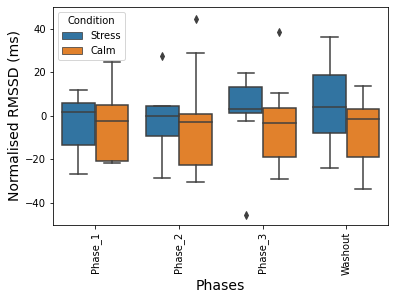

In [30]:
ax1 = sns.boxplot(data=newDF[excludeBase], x='phase', y='RMSSD_Normed',hue='Condition')
ax1.tick_params(axis='x', rotation=90)
plt.xlabel('Phases',fontsize=14)
plt.ylabel('Normalised RMSSD (ms)',fontsize=14)
plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)
plt.ylim([-50,50])

In [50]:
len(pd.unique(newDF['Participant_ID']))

41

,W,pval,normal
RMSSD_Normed,0.500737,1.447116e-19,False


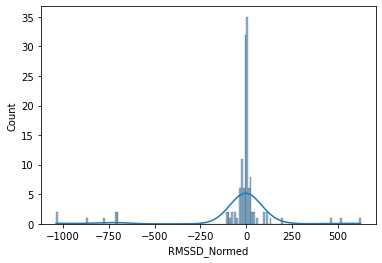

In [31]:
sns.histplot(newDF[excludeBase]['RMSSD_Normed'],kde=True)
pg.normality(newDF[excludeBase]['RMSSD_Normed'])

### Take out outliers from the RMSSD Normalised data

In [49]:
len(pd.unique(newDF_nB['Participant_ID']))

39

In [32]:
newDF_nB = newDF[excludeBase]

newDF_nB

,Participant_ID,Condition,phase,RMSSD,RMSSD_Normed
11,AC071320,Stress,Phase_1,125.932734,64.016414
12,AC071320,Stress,Phase_2,195.062709,133.146388
13,AC071320,Stress,Phase_3,160.551419,98.635098
14,AC071320,Stress,Washout,84.182225,22.265905
22,AM051035,Calm,Phase_1,36.725050,20.920691
...,...,...,...,...,...
416,xd,Calm,Washout,10.873803,-2.567855
423,yu191230,Stress,Phase_1,12.976527,-15.917071
424,yu191230,Stress,Phase_2,56.628589,27.734991
425,yu191230,Stress,Phase_3,225.147473,196.253875


In [33]:
newDF_nB2 = newDF_nB[newDF_nB['RMSSD_Normed'] < 50.0]
newDF_nB3 = newDF_nB2[newDF_nB2['RMSSD_Normed'] > -50.0]

newDF_nB3

,Participant_ID,Condition,phase,RMSSD,RMSSD_Normed
14,AC071320,Stress,Washout,84.182225,22.265905
22,AM051035,Calm,Phase_1,36.725050,20.920691
23,AM051035,Calm,Phase_2,60.413437,44.609077
24,AM051035,Calm,Phase_3,19.983968,4.179608
25,AM051035,Calm,Washout,15.878893,0.074533
...,...,...,...,...,...
415,xd,Calm,Phase_3,13.664677,0.223020
416,xd,Calm,Washout,10.873803,-2.567855
423,yu191230,Stress,Phase_1,12.976527,-15.917071
424,yu191230,Stress,Phase_2,56.628589,27.734991


In [48]:
len(pd.unique(newDF_nB3['Participant_ID']))

31

<ipython-input-34-775451c6bd47>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)


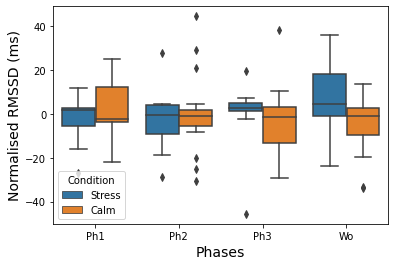

In [34]:
order = ['Phase_1','Phase_2','Phase_3','Washout']
ax1 = sns.boxplot(data=newDF_nB3, x='phase', y='RMSSD_Normed',hue='Condition',order=order)
# ax1.tick_params(axis='x', rotation=90)
plt.xlabel('Phases',fontsize=14)
plt.ylabel('Normalised RMSSD (ms)',fontsize=14)
plt.xticks([0,1,2,3], ['Ph1','Ph2','Ph3','Wo'])

plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)
# plt.ylim([-50,50])

,W,pval,normal
RMSSD_Normed,0.954332,0.000907,False


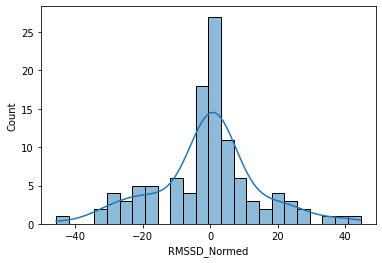

In [35]:
sns.histplot(newDF_nB3['RMSSD_Normed'],kde=True)
pg.normality(newDF_nB3['RMSSD_Normed'])

In [61]:
print('Calm')

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_1')
print('Mean RMSSD phase_1: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_2')
print('Mean RMSSD phase_2: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_3')
print('Mean RMSSD phase_3: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Washout')
print('Mean RMSSD washout: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))



print('\nStress')




mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Stress') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_1')
print('Mean RMSSD phase_1: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Stress') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_2')
print('Mean RMSSD phase_2: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Stress') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_3')
print('Mean RMSSD phase_3: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Stress') &  (newDF_nB3[excludeBase]['phase'] == 'Washout')
print('Mean RMSSD washout: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))



Calm
Mean RMSSD phase_1: 1.427 SD: 14.425
Mean RMSSD phase_2: 0.192 SD: 18.351
Mean RMSSD phase_3: -3.153 SD: 15.876
Mean RMSSD washout: -5.137 SD: 13.677

Stress
Mean RMSSD phase_1: -2.054 SD: 10.796
Mean RMSSD phase_2: -2.241 SD: 13.306
Mean RMSSD phase_3: -0.084 SD: 15.365
Mean RMSSD washout: 6.293 SD: 15.44


<ipython-input-61-652a9edafdb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_1')
<ipython-input-61-652a9edafdb6>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[e

In [68]:
md = smf.mixedlm("RMSSD_Normed ~ (phase*Condition)", data=newDF_nB3, groups=newDF_nB3["Participant_ID"])
mdf = md.fit()
print(mdf.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        RMSSD_Normed
No. Observations:          109            Method:                    REML        
No. Groups:                31             Scale:                     107.2125    
Min. group size:           1              Log-Likelihood:            -415.7741   
Max. group size:           4              Converged:                 Yes         
Mean group size:           3.5                                                   
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.793    4.137  0.433 0.665  -6.315  9.901
phase[T.Phase_2]                      -2.376    3.763 -0.631 0.528  -9.751  4.999
phase[T.Phase_3]                      

In [37]:
# # newDF['RMSSD_Normed'] = newDF['Participant_ID']['Baseline'] - newDF['Participant_ID']['Baseline']
# newDFb = None
# newDFb = newDF[excludePhases].groupby(['Participant_ID','Condition', 'phase']).apply(lambda x: RMSSD_Baseline(x)).reset_index()

# newDFb

<ipython-input-38-c917844f94af>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RMSSD.png', dpi=350, bbox_inch=True)


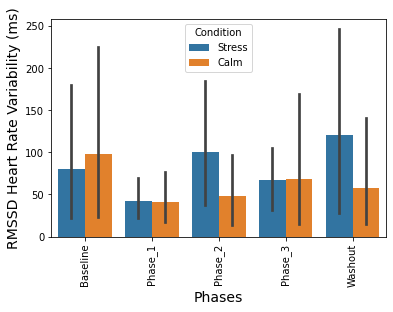

In [38]:
ax1 = sns.barplot(data=newDF[excludePhases], x='phase', y='RMSSD',hue='Condition')
ax1.tick_params(axis='x', rotation=90)
plt.xlabel('Phases',fontsize=14)
plt.ylabel('RMSSD Heart Rate Variability (ms)',fontsize=14)
plt.savefig('RMSSD.png', dpi=350, bbox_inch=True)

In [39]:
ax1 = sns.barplot(data=newDFb, x='phase', y='RMSSD',hue='Condition')
ax1.tick_params(axis='x', rotation=90)

plt.xlabel('Phases',fontsize=14)
plt.ylabel('RMSSD Heart Rate Variability (ms)',fontsize=14)
plt.savefig('RMSSD.png', dpi=350, bbox_inch=True)

NameError: name 'newDFb' is not defined

In [ ]:
# pg.anova(dv=0, between='Condition', effsize="np2", data=newDF).round(3)

pg.mixed_anova(dv=0, between='Condition', within='phase',
               subject='Participant_ID', effsize="ng2", data=newDF[excludePhases]).round(3)

## This is how to report the Linear Mixed Effect model results

In [72]:
print('beta = COEFF_value, SE = se_value, p = p_value')



beta = COEFF_value, SE = se_value, p = p_value


Under methods
Hardware


We used an Valve Index (Valve Corp. WA, USA) 3D immersive VR headset, running at a frame rate of 120 Hz, through an Intel i7 central processing unit Windows 10 PC with a Nvidia GTX-1080Ti graphics processing unit. The virtual environment was created from scratch using the Unreal Engine v5.3.2 (Epic Games, NC, USA) and played through the engine directly to the headset. 